In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

In [2]:
class NN(object):
    def __init__(self,hidden_dims=(1024,2048),n_hidden=2,input_dim=784,n_class=10,datapath=None):
        self.hidden_dims = hidden_dims
        self.n_hidden = n_hidden
        self.input_dim = input_dim
        self.dims = [input_dim]
        self.dims.extend(hidden_dims)
        self.dims.append(n_class)
        self.n_class = n_class
        
        self.data = np.load(datapath)
        self.train_data = self.data[0]
        self.val_data = self.data[1]
        self.test_data = self.data[2]

        self.train_data[0] = self.train_data[0].T
        self.val_data[0] = self.val_data[0].T
        self.test_data[0] = self.test_data[0].T
      
    def initialize_weights(self,init_method):
        n_params = 0
        params = {}
        
        if init_method == 'normal':
            for i in range(self.n_hidden+1):
                W = np.random.randn(self.dims[i+1],self.dims[i])
                b = np.zeros((self.dims[i+1],1))

                params.update({"W"+str(i+1):W, "b"+str(i+1):b})
                n_params += W.size + b.size

            print('Number of parameters : ', n_params)
            return params
        
        if init_method == 'zeros':
            for i in range(self.n_hidden+1):
                W = np.zeros((self.dims[i+1],self.dims[i]))
                b = np.zeros((self.dims[i+1],1))

                params.update({"W"+str(i+1):W, "b"+str(i+1):b})
                n_params += W.size + b.size

            print('Number of parameters : ', n_params)
            return params
        
        if init_method == 'glorot':
            for i in range(self.n_hidden+1):
                d = np.sqrt(6.0/(self.dims[i]+self.dims[i+1]))
                W = np.random.uniform(-d,d,(self.dims[i+1],self.dims[i]))
                b = np.zeros((self.dims[i+1],1))
                params.update({"W"+str(i+1):W, "b"+str(i+1):b})
                n_params += W.size + b.size

            print('Number of parameters : ', n_params)
            return params
        
    def activation(self,z):
        a = np.maximum(0,z)
        return a
    
    def softmax(self,z):
        exps = np.exp(z - np.max(z, axis=0))
        return exps / np.sum(exps, axis=0)
        
    def forward(self,X,params):
        cache = {}
        a = X
        for i in range(self.n_hidden):
            W = params["W"+str(i+1)]
            b = params["b"+str(i+1)]
            
            o = np.dot(W,a)+b
            a = self.activation(o)
            cache.update({"o"+str(i+1):o, "a"+str(i+1):a})
            
        #Softmax activation
        W = params["W"+str(self.n_hidden+1)]
        b = params["b"+str(self.n_hidden+1)]
        o = np.dot(W,a)+b
        a = self.softmax(o)
        cache.update({"o"+str(self.n_hidden+1):o, "a"+str(self.n_hidden+1):a})
        
        return a,cache
    
    def loss(self,prediction,y):
        prediction = np.multiply(prediction, y)
        precision = np.max(prediction, axis=1)
        log_precision = np.log(precision, out=np.zeros_like(precision), where=(precision != 0))
        log_err = np.multiply(log_precision, -1)
        err = np.mean(log_err)
        return err
    
    def backward(self,params,cache,y,X):
        grads = {}
        #number of examples
        n = len(y)
        dZ = cache["a"+str(self.n_hidden+1)]-y.T
        dW = (1./n)*np.dot(dZ,cache["a"+str(self.n_hidden)].T)
        db = (1./n)*np.sum(dZ, axis=1, keepdims=True)
        
        grads.update({"dW"+str(self.n_hidden+1):dW, "db"+str(self.n_hidden+1):db})
        
        for i in range(self.n_hidden,0,-1):
            d_relu = cache["o"+str(i)]
            d_relu[d_relu<=0] = 0
            d_relu[d_relu>0] = 1
            
            dZ = np.dot(params["W"+str(i+1)].T,dZ)*d_relu
            if i == 1:
                a = X
            else:
                a = cache["a"+str(i-1)]
                
            dW = (1./n) * np.dot(dZ, a.T)
            db = (1./n) * np.sum(dZ, axis=1, keepdims=True)
            grads.update({"dW"+str(i):dW, "db"+str(i):db})
            
        return grads
    
    def update(self,grads,params,learning_rate):
        for i in range(self.n_hidden+1):
            W = params["W"+str(i+1)]
            b = params["b"+str(i+1)]

            W = W - learning_rate*grads["dW"+str(i+1)]
            b = b - learning_rate* grads["db"+str(i+1)]
            
            params.update({"W"+str(i+1):W, "b"+str(i+1):b})
        return params
            
    def train(self,iterations,learning_rate,X,labels,init_method,mini_batch=64):
        
        y = np.eye(self.n_class)[labels]
        params = self.initialize_weights(init_method)
        loss = []
        train_acc = []
        val_acc = []
        nb_batchs = int(np.ceil(float(len(y)) / mini_batch))
        batch_X = np.zeros((X.shape[0], mini_batch))
        batch_y = np.zeros((mini_batch, y.shape[1]))

        for i in range(iterations):
            print("Epoch: "+str(i)+"/"+str(iterations))
            s = 0
            batch_X = np.zeros((X.shape[0], mini_batch))
            batch_y = np.zeros((mini_batch, y.shape[1]))
        
            losses = []
            for batch in range(nb_batchs):
                e = s + mini_batch
                if(e > X.shape[1]):
                    e = X.shape[1]
                    
                batch_X = X[:, s:e]
                batch_y = y[s:e, :]
                s = e
                
                #Forward
                output,cache = self.forward(batch_X,params)
                #Backward
                grads = self.backward(params,cache,batch_y,batch_X)
                #Update
                params = self.update(grads,params,learning_rate)
                
                losses.append(self.loss(output,batch_y.T))
            loss.append(np.sum(losses)/len(losses))
            print("Train loss: "+str(np.sum(losses)/len(losses)))
            acc = self.test(self.train_data[0], self.train_data[1], params)
            print('Training Acc : %.3f ' % acc)
            train_acc.append(acc)
            acc = self.test(self.val_data[0], self.val_data[1], params)
            print('Validation Acc : %.3f ' % acc)
            val_acc.append(acc)
            
        return params
    
    def test(self,X,y,params):
        out, cache = self.forward(X, params)
        predicted = np.argmax(out,axis=0)
        total = X.shape[1]
        correct = np.sum(predicted==y)
        acc = 100.*correct/total
        return acc
    
    def plot_loss(self,loss,init_method):
        epoch = range(len(loss)-1)
        plt.plot(epoch,loss[1:])
        plt.title('Training loss using '+init_method+' initialization')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.savefig('zeros_init.jpg')

In [15]:
nn = NN(hidden_dims=(400,500), n_hidden=2, datapath='./dataset/mnist.pkl.npy')
# loss_zeros = nn.train(10, 0.01, nn.train_data[0], nn.train_data[1],mini_batch=32,init_method='zeros')
# loss_normal = nn.train(10, 0.01, nn.train_data[0], nn.train_data[1],mini_batch=32,init_method='normal')
train_acc, val_acc = nn.train(10, 0.01, nn.train_data[0], nn.train_data[1],mini_batch=16,init_method='glorot')

Number of parameters :  519510
Epoch: 0/10
Train loss: 0.25593769037455016
Training Acc : 91.492 
Validation Acc : 92.580 
Epoch: 1/10
Train loss: 0.09373878485345045
Training Acc : 94.012 
Validation Acc : 94.730 
Epoch: 2/10
Train loss: 0.06922970173008977
Training Acc : 95.348 
Validation Acc : 95.590 
Epoch: 3/10
Train loss: 0.054696511054486634
Training Acc : 96.252 
Validation Acc : 96.200 
Epoch: 4/10
Train loss: 0.04491468685804868
Training Acc : 96.860 
Validation Acc : 96.620 
Epoch: 5/10
Train loss: 0.037825056948380564
Training Acc : 97.280 
Validation Acc : 96.920 
Epoch: 6/10
Train loss: 0.03248332203043762
Training Acc : 97.678 
Validation Acc : 97.120 
Epoch: 7/10
Train loss: 0.028256238046390672
Training Acc : 97.970 
Validation Acc : 97.170 
Epoch: 8/10
Train loss: 0.024774225345053146
Training Acc : 98.216 
Validation Acc : 97.280 
Epoch: 9/10
Train loss: 0.021843922321605667
Training Acc : 98.398 
Validation Acc : 97.360 


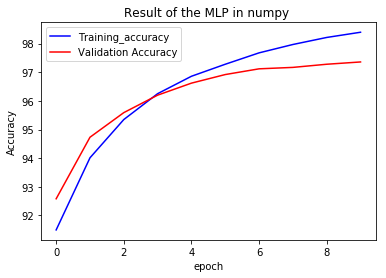

In [17]:
plt.figure()
plt.plot(range(10),train_acc,'b',label='Training_accuracy')
plt.plot(range(10),val_acc,'r',label='Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Result of the MLP in numpy ')
plt.legend()
plt.savefig('accuracy.jpg')

In [4]:
# plt.figure()
# plt.plot(range(10),loss_zeros,'b',label='zeros init')
# plt.plot(range(10),loss_normal,'g',label='normal init')
# plt.plot(range(10),loss_glorot,'r',label='glorot init')
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.title('Training loss')
# plt.legend()
# plt.savefig('training_loss_inits.jpg')

## Hyperparameter search 

In [ ]:
hyper_parameters={"model_architecture":[(400,500),(500,600),(600,500),(500,700)],"learning_rate":[0.1,0.01,0.001,0.0001],"non_linearity":['softmax','tanh'],"mini_batch":[16,32,64]}

for model_architecture in hyper_parameters["model_architecture"]:
    for learning_rate in hyper_parameters["learning_rate"]:
    
        for mini_batch in hyper_parameters["mini_batch"]:
            print(f'Results of the model_architecture= {model_architecture} , learning_rate={learning_rate} , mini_batch={mini_batch}')
            nn = NN(hidden_dims=model_architecture, n_hidden=2, datapath='./mnist.pkl.npy')
            params = nn.train(10, learning_rate, nn.train_data[0], nn.train_data[1],mini_batch=mini_batch,init_method='glorot')

## Validate gradients using finite difference

In [23]:
import time
nn = NN(hidden_dims=(400,500), n_hidden=2, datapath='./dataset/mnist.pkl.npy')
t1 = time.time()
params  = nn.train(10, 0.01, nn.train_data[0], nn.train_data[1],mini_batch=32,init_method='glorot')    
t2 = time.time()
print('Time taken: ',(t2-t1)/60,'min')

Number of parameters :  519510
Epoch: 0/10
Train loss: 0.3379651499875689
Training Acc : 89.866 
Validation Acc : 91.230 
Epoch: 1/10
Train loss: 0.06488572268042947
Training Acc : 92.174 
Validation Acc : 92.920 
Epoch: 2/10
Train loss: 0.04720898935605427
Training Acc : 93.462 
Validation Acc : 94.030 
Epoch: 3/10
Train loss: 0.03766923681418637
Training Acc : 94.416 
Validation Acc : 94.890 
Epoch: 4/10
Train loss: 0.03137939227196039
Training Acc : 95.148 
Validation Acc : 95.470 
Epoch: 5/10
Train loss: 0.026863735937019205
Training Acc : 95.646 
Validation Acc : 95.930 
Epoch: 6/10
Train loss: 0.0233967802358234
Training Acc : 96.060 
Validation Acc : 96.200 
Epoch: 7/10
Train loss: 0.020636780214985207
Training Acc : 96.446 
Validation Acc : 96.480 
Epoch: 8/10
Train loss: 0.018402605368968223
Training Acc : 96.808 
Validation Acc : 96.760 
Epoch: 9/10
Train loss: 0.016537375737336622
Training Acc : 97.130 
Validation Acc : 96.930 
Time taken:  3.496595573425293 min


In [26]:
y = np.zeros(1)
x = np.zeros((784,1))
x[:,0], y[0] = nn.train_data[0][:,0], nn.train_data[1][0]
_,cache =  nn.forward(x,params)
grads = nn.backward(params,cache,y,x)
N_values = [k * 10**i for i in range(0, 5) for k in range(1, 5)]
print(len(N_values))
layer = 1
max_diff = []
for N in N_values:
    print("N = ",N)
    eps = 1.0/N
    delta = []
    for i,(W,dW) in enumerate(zip(params["W"+str(layer)],grads["dW"+str(layer)])):
        for j,(w,dw) in enumerate(zip(W,dW)):
            if i>10:
                break
            params["W"+str(layer)][i][j] = w + eps
            output1,_ = nn.forward(x,params)
            loss1 = nn.loss(output1,y)
            params["W"+str(layer)][i][j] = w - eps
            output2,_ = nn.forward(x,params)
            loss2 = nn.loss(output2,y)
            params["W"+str(layer)][i][j] = w
            est_grad = (loss1-loss2)/(2*eps)
            delta.append(abs(est_grad-dw))
    max_diff.append(np.max(delta))


20
N =  1
N =  2
N =  3
N =  4
N =  10
N =  20
N =  30
N =  40
N =  100
N =  200
N =  300
N =  400
N =  1000
N =  2000
N =  3000
N =  4000
N =  10000
N =  20000
N =  30000
N =  40000


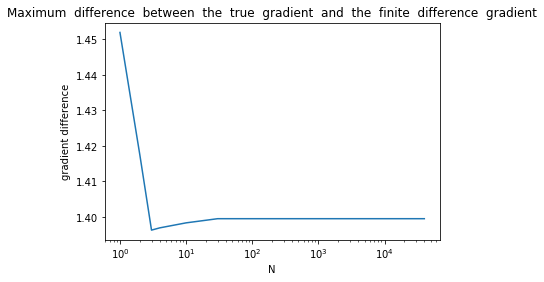

In [27]:
plt.figure()
plt.semilogx(N_values,max_diff)
plt.xlabel('N')
plt.ylabel('gradient difference')
plt.title('Maximum  difference  between  the  true  gradient  and  the  finite  difference  gradient')
plt.savefig('finite_diff.jpg')